In [ ]:
!pip install chembl_webresource_client rdkit pandas matplotlib seaborn --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 5.1 MB/s eta 0:00:00


In [ ]:
# =======================
# STEP 1: Install Libraries
# =======================
# Uncomment and run this cell if you haven't already installed the required packages.
# !pip install rdkit-pypi pandas chembl_webresource_client

# =======================
# STEP 2: Import Modules
# =======================
import pandas as pd
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski, rdMolDescriptors, QED

# =======================
# STEP 3: Define Functions
# =======================
def standardize_smiles(smiles):
    """
    Standardizes a SMILES string to its canonical form.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            Chem.SanitizeMol(mol)
            return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None
    return None

def compute_descriptors(smiles):
    """
    Computes molecular descriptors for a given SMILES string.
    Returns MW, LogP, HBD, HBA, TPSA, NumRotatableBonds.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * 6
    return [
        Descriptors.MolWt(mol),
        Crippen.MolLogP(mol),
        Lipinski.NumHDonors(mol),
        Lipinski.NumHAcceptors(mol),
        rdMolDescriptors.CalcTPSA(mol),
        Lipinski.NumRotatableBonds(mol),
    ]

def fetch_drd2_binding_molecules(max_molecules=500):
    """
    Fetches DRD2 binding molecules from ChEMBL, filters them based on
    IC50, QED, and applies Peifer BBB rules and CNS MPO score.
    """
    activity = new_client.activity
    assay = new_client.assay
    molecule = new_client.molecule

    target_chembl_id = "CHEMBL217"  # DRD2 CHEMBL ID

    # Step 1: Fetch activity data for DRD2
    print(f"Fetching activity data for DRD2 (CHEMBL ID: {target_chembl_id})...")
    results = activity.filter(
        target_chembl_id=target_chembl_id,
        standard_type="IC50",
        standard_units="nM",
        standard_relation__in=["=", "<", "<<"],  # Include values less than or equal
    ).only("molecule_chembl_id", "standard_value", "assay_chembl_id")

    df = pd.DataFrame(results)
    df = df.dropna(subset=["standard_value"])
    df["standard_value"] = pd.to_numeric(df["standard_value"], errors="coerce")
    df = df.dropna(subset=["standard_value"])

    # Step 2: Keep only binding assays and fetch assay description
    print("Filtering by assay type 'B' (Binding) and fetching assay descriptions...")
    assay_cache = {}
    def get_assay_info(assay_id):
        if assay_id in assay_cache:
            return assay_cache[assay_id]
        data = assay.get(assay_id)
        assay_type = data.get("assay_type") if data else None
        assay_description = data.get("description") if data else None
        assay_cache[assay_id] = (assay_type, assay_description)
        return assay_type, assay_description

    assay_info = df["assay_chembl_id"].apply(get_assay_info)
    df["assay_type"] = [info[0] for info in assay_info]
    df["assay_description"] = [info[1] for info in assay_info]
    df = df[df["assay_type"] == "B"]

    # Step 3: Get SMILES
    print("Fetching SMILES for each molecule...")
    smiles_list = []
    for mol_id in df["molecule_chembl_id"]:
        mol_data = molecule.get(mol_id)
        struct = mol_data.get("molecule_structures", {}) if mol_data else {}
        smiles_list.append(struct.get("canonical_smiles"))
    df["canonical_smiles"] = smiles_list

    # Step 4: Standardize SMILES
    print("Standardizing SMILES...")
    df["canonical_smiles"] = df["canonical_smiles"].apply(standardize_smiles)
    df = df.dropna(subset=["canonical_smiles", "standard_value"])
    df = df.drop_duplicates(subset=["canonical_smiles"])

    # Step 5: Compute descriptors
    print("Computing molecular descriptors...")
    descriptors = df["canonical_smiles"].apply(compute_descriptors)
    desc_df = pd.DataFrame(
        descriptors.tolist(),
        columns=["MW", "LogP", "HBD", "HBA", "TPSA", "NumRotatableBonds"]
    )
    df = pd.concat([df.reset_index(drop=True), desc_df], axis=1)
    df = df.dropna()

    # Step 6: Compute QED
    print("Computing QED scores...")
    df["QED"] = df["canonical_smiles"].apply(
        lambda s: QED.qed(Chem.MolFromSmiles(s)) if Chem.MolFromSmiles(s) else None
    )
    df = df.dropna(subset=["QED"])

    # Step 7: Apply filters for activity class, Peifer BBB, and CNS MPO
    print("Applying activity class, Peifer BBB, and CNS MPO rules...")
    def classify_and_score(row):
        qed = row["QED"]
        ic50 = row["standard_value"]
        mw = row["MW"]
        logp = row["LogP"]
        tpsa = row["TPSA"]
        hbd = row["HBD"]
        hba = row["HBA"]
        num_rotatable_bonds = row["NumRotatableBonds"]

        # Activity Class
        activity_class = "Low"
        if qed >= 0.75 and ic50 < 100:
            activity_class = "High"
        elif qed >= 0.6 and ic50 < 1000:  # Moderate activity and QED
            activity_class = "Moderate"

        # Peifer BBB rule: LogP <= 5 AND TPSA <= 90
        bbb_perm = "Yes" if (logp <= 5) and (tpsa <= 90) else "No"

        # CNS MPO Score (based on Peifer-like criteria)
        cns_mpo_score = sum([
            mw < 450,
            logp < 5,
            tpsa < 90,
            hbd <= 10,
            hba <= 10,
            num_rotatable_bonds <= 10,
            (logp - 0.2 * tpsa) > -2
        ])
        return activity_class, bbb_perm, cns_mpo_score

    df[["Activity_Class", "BBB_Permeable", "CNS_MPO_Score"]] = df.apply(
        lambda row: pd.Series(classify_and_score(row)), axis=1
    )

    # Filter for 'High' and 'Moderate' activity molecules and BBB permeable
    df = df[df["Activity_Class"].isin(["High", "Moderate"]) & (df["BBB_Permeable"] == "Yes")]

    # Sort by QED and CNS_MPO_Score (higher is better) and then IC50 (lower is better)
    df = df.sort_values(by=["QED", "CNS_MPO_Score", "standard_value"], ascending=[False, False, True])

    # Step 8: Final cleanup and limit max_molecules
    df = df.head(max_molecules)

    # Rename and reorder - REMOVED 'assay_chembl_id'
    df = df.rename(columns={"standard_value": "IC50_nM"})
    df = df[
        [
            "molecule_chembl_id", "canonical_smiles", "IC50_nM", "QED",
            "MW", "LogP", "HBD", "HBA", "TPSA", "NumRotatableBonds",
            "assay_description", "Activity_Class",
            "BBB_Permeable", "CNS_MPO_Score"
        ]
    ]

    print(f"\n✅ Fetched {len(df)} potent and moderate DRD2 inhibitors, BBB permeable with high QED.\n")
    return df

# =======================
# STEP 4: Run and Save
# =======================
df_drd2 = fetch_drd2_binding_molecules(max_molecules=500)
df_drd2.to_csv("drd2_bbb_permeable_high_moderate_qed_binding_500_rdkit.csv", index=False)
print(df_drd2.head())

Fetching activity data for DRD2 (CHEMBL ID: CHEMBL217)...
Filtering by assay type 'B' (Binding) and fetching assay descriptions...
Fetching SMILES for each molecule...
Standardizing SMILES...
Computing molecular descriptors...
Computing QED scores...
Applying activity class, Peifer BBB, and CNS MPO rules...

✅ Fetched 119 potent and moderate DRD2 inhibitors, BBB permeable with high QED.

    molecule_chembl_id                                   canonical_smiles  \
269      CHEMBL2057453          COc1ccc2c(c1)C[C@H]1c3cc(O)c(OC)cc3CCN1C2   
195          CHEMBL531  CCCN1C[C@H](CSC)C[C@@H]2c3cccc4[nH]cc(c34)C[C@...   
83        CHEMBL326962       O=C1NCN(c2ccccc2)C12CCN(Cc1ccc3c(c1)OCO3)CC2   
206       CHEMBL157138  CCN(CC)C(=O)N[C@H]1C=C2c3cccc4[nH]cc(c34)C[C@H...   
296      CHEMBL3299093              COc1ccccc1N1CCN(CCNC(=O)OC(C)(C)C)CC1   

     IC50_nM       QED       MW    LogP  HBD  HBA   TPSA  NumRotatableBonds  \
269   873.14  0.925371  311.381  3.0649    1    4  41.93           

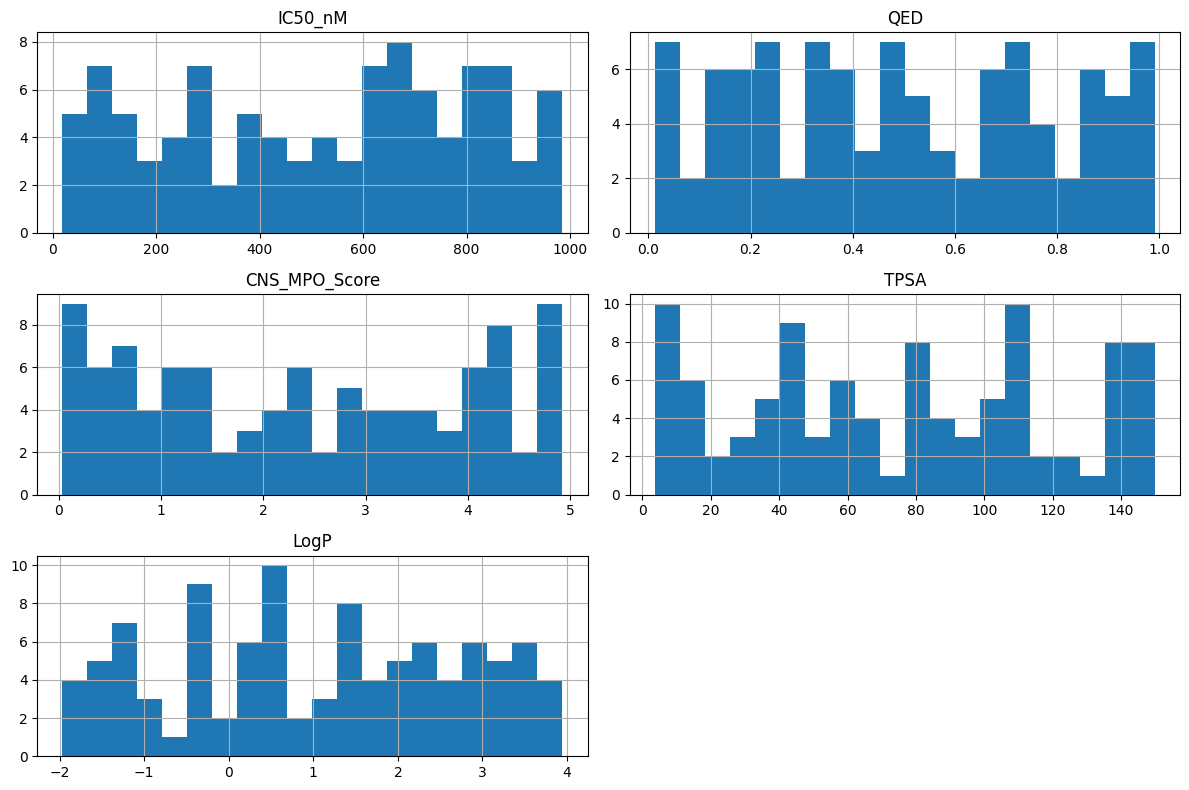

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distributions
df_drd2.hist(column=["IC50_nM", "QED", "CNS_MPO_Score", "TPSA", "LogP"], bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()


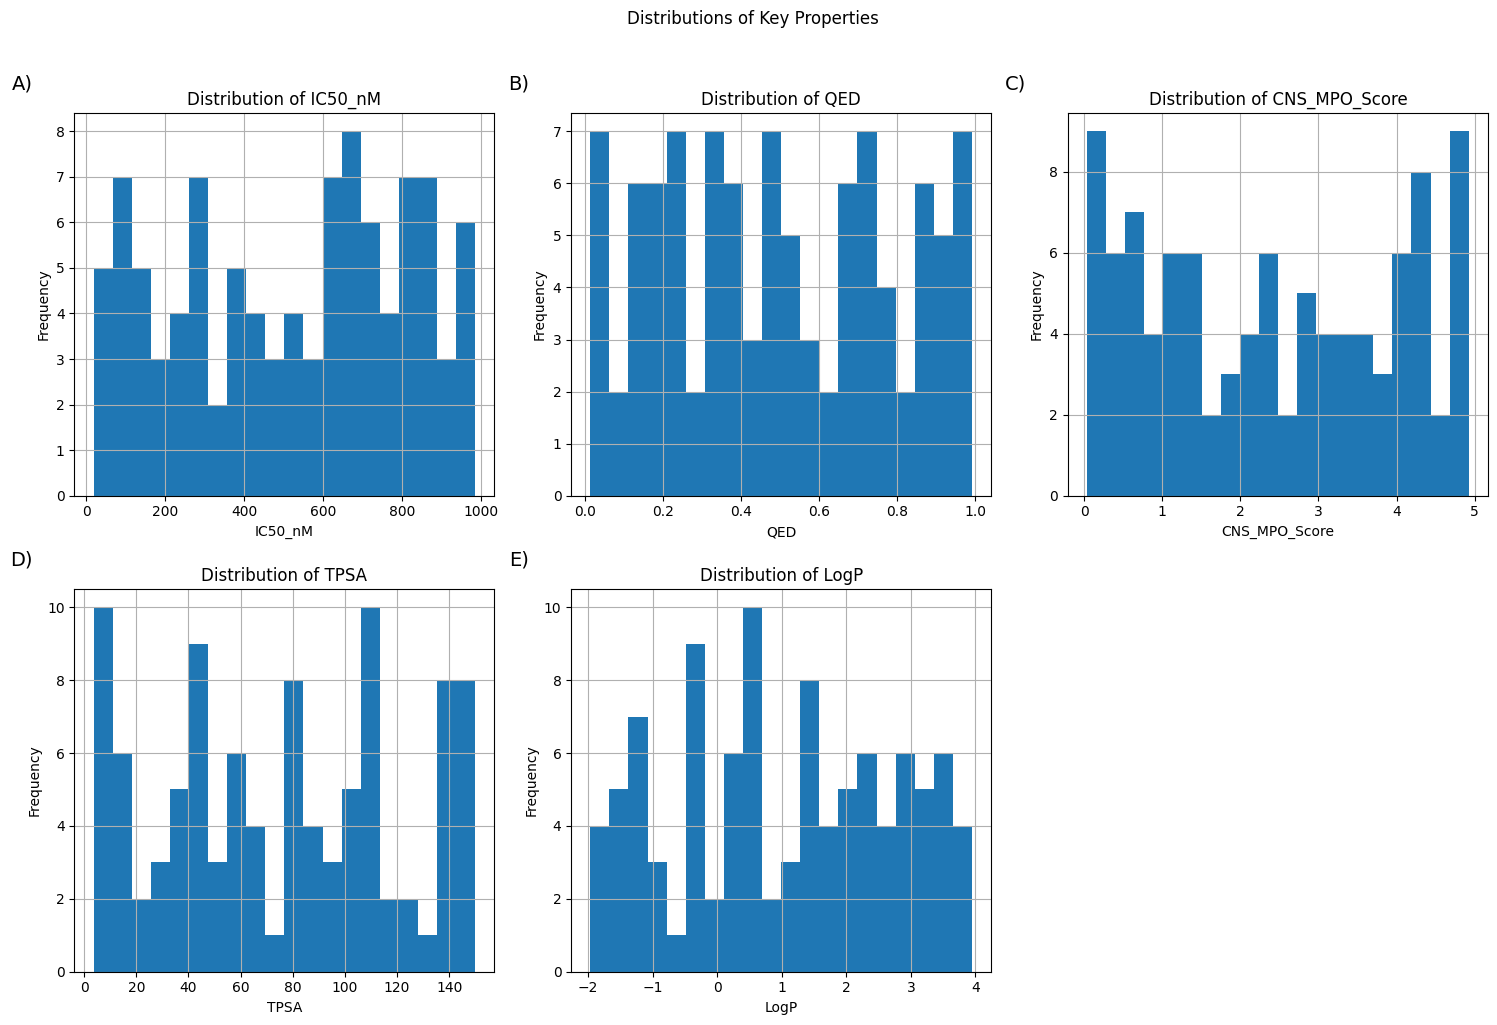

In [ ]:
# prompt: I WANT TO SAVE THE OUT OF THE ABOVE PRODUCED GRAPHS ALSO NAME THE EACH GRAPH WITH A),B),C),D),E) FOR AT THE CORNER OF THE EACH GRAPH  NOT INSIDE THE GRAPH PICTURES OUTSIDE OF THE GEAPH

import matplotlib.pyplot as plt
# Distributions
# Save plots and add labels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Distributions of Key Properties", y=1.02)  # Add a title to the entire figure

axs = axes.flatten()

# Define columns and corresponding labels
plot_cols = ["IC50_nM", "QED", "CNS_MPO_Score", "TPSA", "LogP"]
plot_labels = ["A)", "B)", "C)", "D)", "E)"] # Labels for each subplot

# Plot each histogram
for i, col in enumerate(plot_cols):
    ax = axs[i]
    df_drd2[col].hist(bins=20, ax=ax)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

    # Add the label (A, B, C, etc.) outside the top-left corner
    ax.text(-0.1, 1.1, plot_labels[i], transform=ax.transAxes, fontsize=14, va='top', ha='right')

# Hide the unused subplot if there's one
if len(plot_cols) < len(axs):
    for i in range(len(plot_cols), len(axs)):
        fig.delaxes(axs[i])

plt.tight_layout()

# Save the figure
plt.savefig("drd2_distributions.png")
plt.show()

In [ ]:

!pip install selfies

In [ ]:
import pandas as pd
import selfies as sf

# Load your CSV (adjust the path if needed)
df = pd.read_csv("drd2_bbb_permeable.csv")

# Extract SMILES column
smiles_list = df['canonical_smiles'].dropna().tolist()

# Convert SMILES to SELFIES
selfies_list = []
invalid_smiles = []

for smi in smiles_list:
    try:
        selfies = sf.encoder(smi)
        selfies_list.append(selfies)
    except Exception as e:
        print(f"Invalid SMILES: {smi} - Error: {e}")
        invalid_smiles.append(smi)

print(f"✅ Total valid SELFIES: {len(selfies_list)}")
print(f"❌ Invalid SMILES skipped: {len(invalid_smiles)}")


✅ Total valid SELFIES: 119
❌ Invalid SMILES skipped: 0


In [ ]:
import selfies as sf

# Step 2: Create vocabulary
unique_tokens = set()

for s in selfies_list:
    tokens = list(sf.split_selfies(s))  # split_selfies returns a generator
    unique_tokens.update(tokens)

# Add special tokens
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
all_tokens = special_tokens + sorted(unique_tokens)

# Create mappings
char_to_idx = {char: idx for idx, char in enumerate(all_tokens)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

# Print summary
print(f"✅ Vocabulary size (including special tokens): {len(char_to_idx)}")
print(f"🔤 Example tokens: {list(char_to_idx.keys())[:15]}")


✅ Vocabulary size (including special tokens): 33
🔤 Example tokens: ['<PAD>', '<SOS>', '<EOS>', '.', '[#Branch1]', '[#Branch2]', '[#C]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=Ring1]', '[Br]', '[Branch1]']


In [ ]:
import pickle

# ... (your existing code to generate char_to_idx and idx_to_char) ...

vocab = {
    "char_to_idx": char_to_idx,
    "idx_to_char": idx_to_char
}

with open("selfies_vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

print("✅ Vocabulary saved to selfies_vocab.pkl")

✅ Vocabulary saved to selfies_vocab.pkl


In [ ]:
import torch

# Initialize list for encoded sequences
encoded_sequences = []

# Loop through all SELFIES strings
for s in selfies_list:
    # Tokenize SELFIES and add start/end tokens
    tokens = ['<SOS>'] + list(sf.split_selfies(s)) + ['<EOS>']

    # Convert tokens to indices
    idx_seq = [char_to_idx[token] for token in tokens if token in char_to_idx]

    # Convert to tensor
    encoded_tensor = torch.tensor(idx_seq, dtype=torch.long)

    # Store
    encoded_sequences.append(encoded_tensor)

print(f"✅ Successfully encoded {len(encoded_sequences)} sequences.")
print(f"📏 Example (first) sequence: {encoded_sequences[0]}")


✅ Successfully encoded 119 sequences.
📏 Example (first) sequence: tensor([ 1, 20, 26, 20,  9, 20,  9, 20,  7, 29,  9, 28,  7, 20, 18, 20,  9, 20,
        14, 20, 26,  9, 14, 28, 26, 20, 20,  9, 28,  8, 20, 20, 24, 28, 10, 20,
        29, 28, 20,  2])


In [ ]:
import torch
print(torch.__version__)


2.6.0+cu124


In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch

# 🧠 Assume PAD_IDX and encoded_sequences are already defined
PAD_IDX = char_to_idx['<PAD>']
# encoded_sequences = [...]  # list of tensors

# A. Define custom dataset
class CustomSelfiesDataset(Dataset):
    def __init__(self, encoded_sequences):
        self.encoded_sequences = encoded_sequences

    def __len__(self):
        return len(self.encoded_sequences)

    def __getitem__(self, idx):
        return self.encoded_sequences[idx]

# B. Define collate function for dynamic padding in DataLoader
def collate_fn(batch):
    return pad_sequence(batch, batch_first=True, padding_value=PAD_IDX)

# C. Create the static padded tensor (optional, for other uses)
padded_seqs_tensor = pad_sequence(encoded_sequences, batch_first=True, padding_value=PAD_IDX)
print(f"✅ padded_seqs_tensor shape: {padded_seqs_tensor.shape}")

# D. Create the dataset and dynamic-padded dataloader
dataset = CustomSelfiesDataset(encoded_sequences)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# E. Try loading a batch
for batch in dataloader:
    print(f"🧪 Dynamic batch shape: {batch.shape}")  # Should be [batch_size, max_seq_len]
    break


✅ padded_seqs_tensor shape: torch.Size([119, 55])
🧪 Dynamic batch shape: torch.Size([32, 51])


In [ ]:
!pip install rdkit-pypi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 65.8 MB/s eta 0:00:00


In [ ]:


from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.model_selection import train_test_split
import torch
from torch.nn.utils.rnn import pad_sequence

# Sample input: encoded_sequences and selfies_list (aligned lists)
# encoded_sequences: list of LongTensors of tokenized SELFIES
# selfies_list: list of original SELFIES strings (needed to get scaffolds)
assert len(encoded_sequences) == len(selfies_list)

# Step 1: Convert SELFIES to SMILES
import selfies as sf
smiles_list = [sf.decoder(s) for s in selfies_list]

# Step 2: Get Murcko scaffolds
def get_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold, isomericSmiles=True)

scaffolds = [get_murcko_scaffold(smi) for smi in smiles_list]

# Step 3: Group indices by scaffold
from collections import defaultdict
scaffold_to_indices = defaultdict(list)
for idx, scaffold in enumerate(scaffolds):
    if scaffold:  # Only include valid scaffolds
        scaffold_to_indices[scaffold].append(idx)

# Step 4: Sort scaffolds by number of molecules (descending)
scaffold_groups = sorted(scaffold_to_indices.values(), key=lambda x: -len(x))

# Step 5: Split into train and validation sets (e.g., 80/20 split)
train_indices, val_indices = [], []
train_cutoff = int(0.8 * len(smiles_list))
count = 0
for group in scaffold_groups:
    if count + len(group) <= train_cutoff:
        train_indices.extend(group)
        count += len(group)
    else:
        val_indices.extend(group)

# Step 6: Prepare padded tensors
train_seqs = [encoded_sequences[i] for i in train_indices]
val_seqs = [encoded_sequences[i] for i in val_indices]

train_tensor = pad_sequence(train_seqs, batch_first=True, padding_value=PAD_IDX)
val_tensor = pad_sequence(val_seqs, batch_first=True, padding_value=PAD_IDX)

train_tensor.shape, val_tensor.shape


(torch.Size([95, 55]), torch.Size([24, 55]))

In [ ]:
import torch

# Save tensors
torch.save(train_tensor, 'train_tensor.pt')
torch.save(val_tensor, 'val_tensor.pt')

print("✅ Saved as 'train_tensor.pt' and 'val_tensor.pt'")



✅ Saved as 'train_tensor.pt' and 'val_tensor.pt'


In [ ]:
# prompt: GENERATE THE CODE WHICH CAN GENERATE THE  ABOVE SPLIT FILES INTO CSV INTO train_selfies.csv, val_selfies.csv

import pandas as pd
# Recreate DataFrames for saving to CSV
train_df_rows = [
    {"selfies": selfies_list[i], "encoded": encoded_sequences[i].tolist()}
    for i in train_indices
]
val_df_rows = [
    {"selfies": selfies_list[i], "encoded": encoded_sequences[i].tolist()}
    for i in val_indices
]

train_df = pd.DataFrame(train_df_rows)
val_df = pd.DataFrame(val_df_rows)

# Save to CSV
train_df.to_csv("train_selfies.csv", index=False)
val_df.to_csv("val_selfies.csv", index=False)

print("✅ Saved 'train_selfies.csv' and 'val_selfies.csv'")

✅ Saved 'train_selfies.csv' and 'val_selfies.csv'


In [ ]:
import pandas as pd

# Make sure these are already defined
# selfies_list : full list of original SELFIES strings (VGFR2 inhibitors)
# smiles_list  : corresponding SMILES strings (decoded from SELFIES)
# train_indices, val_indices : from your scaffold splitting logic

# Extract training and validation splits using indices
train_selfies = [selfies_list[i] for i in train_indices]
val_selfies = [selfies_list[i] for i in val_indices]

train_smiles = [smiles_list[i] for i in train_indices]
val_smiles = [smiles_list[i] for i in val_indices]

# Create pandas DataFrames
train_df = pd.DataFrame({
    "SELFIES": train_selfies,
    "SMILES": train_smiles
})

val_df = pd.DataFrame({
    "SELFIES": val_selfies,
    "SMILES": val_smiles
})

# Save to CSV
train_df.to_csv("train_selfies.csv", index=False)
val_df.to_csv("val_selfies.csv", index=False)

print("✅ Saved scaffold-split DRD2 SELFIES to 'train_selfies.csv' and 'val_selfies.csv'")


✅ Saved scaffold-split DRD2 SELFIES to 'train_selfies.csv' and 'val_selfies.csv'


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Step 1: Load padded tokenized sequences
train_tensor = torch.load("train_tensor.pt")  # shape: [num_train, max_seq_len]
val_tensor = torch.load("val_tensor.pt")      # shape: [num_val, max_seq_len]

print("✅ Loaded tensors:")
print(f"Train tensor shape: {train_tensor.shape}")
print(f"Val tensor shape: {val_tensor.shape}")

# Step 2: Wrap tensors in TensorDataset
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)

# Step 2b: Create DataLoaders
batch_size = 32  # Adjust based on available memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Step 2c: Check a batch
for (batch,) in train_loader:
    print(f"🔎 One training batch shape: {batch.shape}")  # Should be [batch_size, max_seq_len]
    break


✅ Loaded tensors:
Train tensor shape: torch.Size([95, 55])
Val tensor shape: torch.Size([24, 55])
🔎 One training batch shape: torch.Size([32, 55])


In [ ]:
import pandas as pd
import selfies as sf
import pickle

# Load SMILES from VEGFR2 dataset
df = pd.read_csv("drd2_bbb_permeable.csv")
smiles_list = df["canonical_smiles"].tolist()

# Convert to SELFIES
selfies_list = [sf.encoder(smi) for smi in smiles_list if sf.encoder(smi) is not None]

# Build vocabulary from SELFIES tokens
unique_tokens = set()
for s in selfies_list:
    unique_tokens.update(sf.split_selfies(s))

# Special tokens
tokens = ['<PAD>', '<SOS>', '<EOS>'] + sorted(list(unique_tokens))
char_to_idx = {c: i for i, c in enumerate(tokens)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

# Save vocab mappings
with open("char_to_idx.pkl", "wb") as f:
    pickle.dump(char_to_idx, f)

with open("idx_to_char.pkl", "wb") as f:
    pickle.dump(idx_to_char, f)

print("Saved: char_to_idx.pkl and idx_to_char.pkl ✅")


Saved: char_to_idx.pkl and idx_to_char.pkl ✅


--- Loading Preprocessed Data ---
Loaded train_tensor.pt with shape: torch.Size([95, 55])
Loaded val_tensor.pt with shape: torch.Size([24, 55])
Train batches: 3, Val batches: 1

--- Loading Vocabulary ---
Vocabulary loaded. Vocab size: 33

--- Using device: cpu ---

--- Model Architecture ---
SelfiesRNN(
  (embedding): Embedding(33, 128, padding_idx=0)
  (gru): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=33, bias=True)
)
Total model parameters: 703905

--- Starting Model Training ---
Epoch 1/20 - Train Loss: 3.2870 - Train Acc: 23.26% - Val Loss: 2.7713 - Val Acc: 36.48%
Epoch 2/20 - Train Loss: 2.6143 - Train Acc: 35.88% - Val Loss: 2.4738 - Val Acc: 36.48%
Epoch 3/20 - Train Loss: 2.4032 - Train Acc: 37.85% - Val Loss: 2.3776 - Val Acc: 35.85%
Epoch 4/20 - Train Loss: 2.2715 - Train Acc: 38.58% - Val Loss: 2.2355 - Val Acc: 36.48%
Epoch 5/20 - Train Loss: 2.1663 - Train Acc: 36.42% - Val Loss: 2.1798 - Val Acc: 36.12%
Epoch 

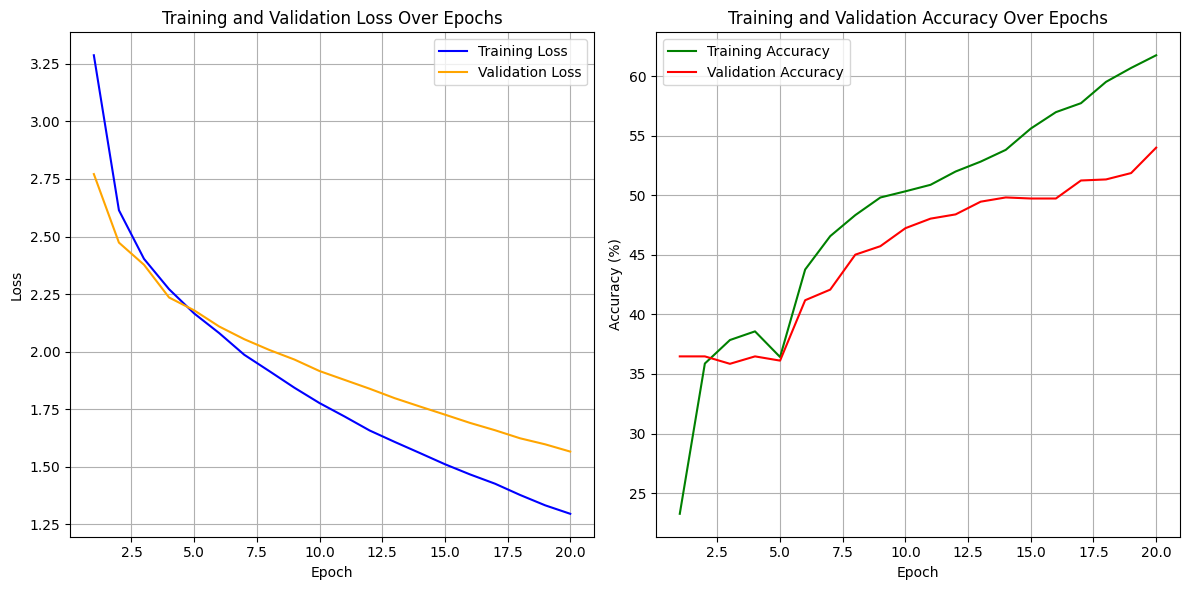

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import sys # Import sys for exit_on_error

# --- IMPORTANT: Ensure these files exist in the same directory! ---
# train_tensor.pt
# val_tensor.pt
# char_to_idx.pkl
# idx_to_char.pkl
# If they don't, you will get a FileNotFoundError.

# --- Configuration (optional, can be adjusted) ---
BATCH_SIZE = 32
EPOCHS = 20 # Your specified epochs for training

# --- Helper Function for Error Handling and Exiting ---
def exit_on_error(message):
    print(f"Error: {message}")
    sys.exit(1)

# -------------------------
# 1. Load Preprocessed Data
# -------------------------
print("--- Loading Preprocessed Data ---")
try:
    train_tensor = torch.load("train_tensor.pt")
    val_tensor = torch.load("val_tensor.pt")
    print(f"Loaded train_tensor.pt with shape: {train_tensor.shape}")
    print(f"Loaded val_tensor.pt with shape: {val_tensor.shape}")
except FileNotFoundError:
    exit_on_error("One or more tensor files ('train_tensor.pt', 'val_tensor.pt') not found. "
                  "Please ensure you have preprocessed the data and saved the tensors in the same directory.")

# DataLoaders
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# -------------------------
# 2. Load Vocabulary
# -------------------------
print("\n--- Loading Vocabulary ---")
try:
    with open("char_to_idx.pkl", "rb") as f:
        char_to_idx = pickle.load(f)

    with open("idx_to_char.pkl", "rb") as f:
        idx_to_char = pickle.load(f)
    print(f"Vocabulary loaded. Vocab size: {len(char_to_idx)}")
except FileNotFoundError:
    exit_on_error("One or more vocabulary files ('char_to_idx.pkl', 'idx_to_char.pkl') not found. "
                  "Please ensure you have created and saved the vocabulary files in the same directory.")

PAD_IDX = char_to_idx.get("<PAD>", -1) # Use .get() with a default for robustness
if PAD_IDX == -1:
    exit_on_error("'<PAD>' token not found in vocabulary. Please ensure your vocabulary includes it.")
vocab_size = len(char_to_idx)

# -------------------------
# 3. Define Model
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n--- Using device: {device} ---")

class SelfiesRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2):
        super(SelfiesRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3 if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.gru(x, hidden)
        logits = self.fc(output)
        return logits, hidden

model = SelfiesRNN(vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("\n--- Model Architecture ---")
print(model)
print(f"Total model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


# -------------------------
# 4. Training Function (Corrected to collect and return losses and accuracies)
# -------------------------
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = [] # List to store training accuracy per epoch
    val_accuracies = []   # List to store validation accuracy per epoch

    for epoch in range(1, epochs + 1):
        # --- Training Phase ---
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train_tokens = 0

        for batch_idx, batch in enumerate(train_loader):
            if isinstance(batch, (list, tuple)):
                batch_tensor = batch[0].to(device)
            else:
                batch_tensor = batch.to(device)

            inputs = batch_tensor[:, :-1]
            targets = batch_tensor[:, 1:]

            optimizer.zero_grad()
            logits, _ = model(inputs)

            # Calculate Loss
            loss = criterion(logits.reshape(-1, vocab_size), targets.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_train_loss += loss.item()

            # Calculate Training Accuracy
            predictions = logits.argmax(dim=-1) # Get predicted token indices
            mask = (targets != PAD_IDX) # Create a mask to ignore padding tokens
            total_train_correct += (predictions == targets)[mask].sum().item() # Count correct non-padding predictions
            total_train_tokens += mask.sum().item() # Count total non-padding tokens

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        avg_train_accuracy = (total_train_correct / total_train_tokens) * 100 if total_train_tokens > 0 else 0
        train_accuracies.append(avg_train_accuracy)

        # --- Validation Phase ---
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_tokens = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                if isinstance(batch, (list, tuple)):
                    batch_tensor = batch[0].to(device)
                else:
                    batch_tensor = batch.to(device)

                inputs = batch_tensor[:, :-1]
                targets = batch_tensor[:, 1:]

                logits, _ = model(inputs)
                loss = criterion(logits.reshape(-1, vocab_size), targets.reshape(-1))
                total_val_loss += loss.item()

                # Calculate Validation Accuracy
                predictions = logits.argmax(dim=-1)
                mask = (targets != PAD_IDX)
                total_val_correct += (predictions == targets)[mask].sum().item()
                total_val_tokens += mask.sum().item()
        model.train() # Set model back to training mode after validation

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        avg_val_accuracy = (total_val_correct / total_val_tokens) * 100 if total_val_tokens > 0 else 0
        val_accuracies.append(avg_val_accuracy)

        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.4f} - Train Acc: {avg_train_accuracy:.2f}% - Val Loss: {avg_val_loss:.4f} - Val Acc: {avg_val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies # Return all collected lists

# -------------------------
# 5. Train the Model and Plot Results
# -------------------------
print("\n--- Starting Model Training ---")
# Capture all returned lists from the train function
train_losses_history, val_losses_history, train_accuracies_history, val_accuracies_history = train(
    model, train_loader, val_loader, optimizer, criterion, epochs=EPOCHS
)
print("--- Model Training Complete ---")

# --- Plotting the loss ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(range(1, len(train_losses_history) + 1), train_losses_history, label='Training Loss', color='blue')
plt.plot(range(1, len(val_losses_history) + 1), val_losses_history, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(range(1, len(train_accuracies_history) + 1), train_accuracies_history, label='Training Accuracy', color='green')
plt.plot(range(1, len(val_accuracies_history) + 1), val_accuracies_history, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjusts plot to prevent labels/titles overlapping
plt.savefig('training_metrics.png') # Saves both plots in one file
print("Training and validation loss and accuracy plots saved as 'training_metrics.png'")

In [ ]:
import random

def sample(model, idx_to_char, char_to_idx, max_len=100, temperature=1.0):
    model.eval()
    generated = [char_to_idx["<SOS>"]]
    input_seq = torch.tensor([[generated[-1]]], device=device)
    hidden = None

    with torch.no_grad():
        for _ in range(max_len):
            logits, hidden = model(input_seq, hidden)
            logits = logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1).squeeze()
            next_token = torch.multinomial(probs, num_samples=1).item()
            if idx_to_char[next_token] == "<EOS>":
                break
            generated.append(next_token)
            input_seq = torch.tensor([[next_token]], device=device)

    # Convert token indices to SELFIES string
    selfies_str = "".join([idx_to_char[idx] for idx in generated[1:]])
    return selfies_str


In [ ]:
# Generate SELFIES strings
generated_selfies = [sample(model, idx_to_char, char_to_idx) for _ in range(100)]

# Show results
for i, s in enumerate(generated_selfies, 1):
    print(f"{i:02d}: {s}")


NameError: name 'model' is not defined

In [ ]:
# Generate SELFIES strings
generated_selfies = [sample(model, idx_to_char, char_to_idx) for _ in range(100)]

# Show results
for i, s in enumerate(generated_selfies, 1):
    print(f"{i:02d}: {s}")


01: [C][O][C][=C][C][=C][C][=C][Branch2][Ring1][P][C][Ring2][C][=C][Branch1][C][=C][C][Branch2][Ring1][Ring1][Ring2][C][C][N][Branch2][Ring1][=N][C][C][C][N][C][Branch1][C][=N][C][=C][C][=C][N][Branch1][C][Cl][C][=C][Ring1][=Branch1][O][C][Ring1][N][C][N][Branch1][C][C][N][Branch1][#C][C][Branch1][C][O][C][=O][N][Branch1][C][N][C][C][Branch1][P][C][C@H1][C][=C][Branch1][Ring1][O][C][C][N][C][Branch1][C][C][C@@H1][Ring1][=Branch1]
02: [C][=N][C][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][=N][C][=C][C][=N][Ring1][=Branch1][C][N][Branch1][#C][O][C][=C][C][=C][C][=C][Ring1][#Branch1][=C][C][Branch2][C][Ring1][=N][C][C][N][C][C][Branch2][Ring1][C][C@H1][Branch1][C][N][C][C][=C][C][=Branch1][C][=C][Ring2][=C][Ring1][=Branch1][N][C][C][N][Branch1][=Branch2][C][=C][C][N][Branch1][=Branch2][C][Ring2][Ring1][#C][=C][Ring2][Ring1][=Branch1]
03: [N][N][Branch1][#C][C][C][C][C][C][N][Branch1][C][C][C][C][C@@H1][C][=C][C][=C][C][=C][Ring1][#Branch1][C][Ring2][Ring1][=Branch1]
04: .[F][C][F][C][=C][C]

In [ ]:
def selfies_to_smiles(selfies_list):
    smiles_list = []
    valid_count = 0

    for s in selfies_list:
        try:
            smi = sf.decoder(s)
            mol = Chem.MolFromSmiles(smi)
            if mol:  # RDKit checks chemical validity
                smiles_list.append(Chem.MolToSmiles(mol))  # Canonicalize
                valid_count += 1
            else:
                smiles_list.append(None)
        except Exception as e:
            smiles_list.append(None)

    print(f"Valid SMILES: {valid_count}/{len(selfies_list)}")
    return smiles_list
# Step 1: Generate SELFIES
generated_selfies = [sample(model, idx_to_char, char_to_idx) for _ in range(100)]

# Step 2: Decode to SMILES and validate
decoded_smiles = selfies_to_smiles(generated_selfies)

# Step 3: Filter valid SMILES
valid_smiles = [smi for smi in decoded_smiles if smi is not None]

# Step 4: Print or save
for i, smi in enumerate(valid_smiles[:10], 1):
    print(f"{i:02d}: {smi}")


Valid SMILES: 99/100
01: CC1=CC=CPCCCCOC1
02: FCNNC1C=CS[C]C=CC=CNC=CC1Cl
03: [CH]CCCN(C)CNNCCC([CH])C=O
04: C=C[C@H]1CON2CCNCCCC=COC12
05: BrC1=CC=COC1
06: ClCCCCCCn1cc2c3cccc(c31)OCCc1ccccc1C2
07: CCCNC=NCOCl
08: ClCC=CNC[C@@H]1C=CC1
09: C=CC=CC=C1CC2=CC(Br)C=CC=CCCC12
10: COC=O


In [ ]:
import pandas as pd

df = pd.DataFrame({"canonical_smiles": valid_smiles})
df.to_csv("generated_valid_smiles.csv", index=False)
print("Saved valid SMILES to 'generated_valid_smiles.csv'")


Saved valid SMILES to 'generated_valid_smiles.csv'


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, QED, rdMolDescriptors


In [ ]:
# ----------------------------
# STEP 8: Compute Descriptors
# ----------------------------

from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, QED, rdMolDescriptors
import pandas as pd
import numpy as np # Import numpy for NaN handling

# --- 1. Load SMILES list from CSV (generated from Step 7) ---
# Assumes you have "generated_valid_smiles.csv" with a column 'canonical_smiles'

try:
    df = pd.read_csv("generated_valid_smiles.csv")
    print(f"Successfully loaded data from 'generated_valid_smiles.csv'.")
except FileNotFoundError:
    print("Error: 'generated_valid_smiles.csv' not found. Please ensure it exists and is in the correct directory.")
    exit() # Exit if the input file is not found

if "canonical_smiles" not in df.columns:
    print("Error: Column 'canonical_smiles' not found in 'generated_valid_smiles.csv'. Please check the column name.")
    exit()

# --- IMPORTANT FIX: Clean and validate SMILES strings ---
# Convert column to string type, replace 'nan' string with empty, then filter out empty strings
valid_smiles = df["canonical_smiles"].astype(str).replace('nan', np.nan).dropna().tolist()
# The above line does:
# 1. .astype(str): Converts all entries to string type.
# 2. .replace('nan', np.nan): Converts the string 'nan' (if any) back to actual NaN.
# 3. .dropna(): Removes any actual NaN values.
# 4. .tolist(): Converts the cleaned Series to a list.

if not valid_smiles:
    print("No valid SMILES strings found in 'generated_valid_smiles.csv' after cleaning. Cannot compute descriptors.")
    exit()
else:
    print(f"Found {len(valid_smiles)} valid SMILES strings for descriptor computation after cleaning.")


# --- 2. Function to calculate descriptors ---
def compute_descriptors(smiles_list):
    descriptor_data = []

    # Ensure that SMILES are strings before passing to RDKit
    # This filter is a safeguard, as the list should already be clean from above.
    clean_smiles_list = [smi for smi in smiles_list if isinstance(smi, str) and smi.strip() != '']

    if not clean_smiles_list:
        print("Warning: No valid SMILES strings to process in compute_descriptors function.")
        return []

    for smi in clean_smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            try:
                data = {
                    "canonical_smiles": smi,
                    "MW": Descriptors.MolWt(mol),
                    "LogP": Crippen.MolLogP(mol),
                    "TPSA": rdMolDescriptors.CalcTPSA(mol),
                    "HBD": rdMolDescriptors.CalcNumHBD(mol),
                    "HBA": rdMolDescriptors.CalcNumHBA(mol),
                    "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
                    "QED": QED.qed(mol)
                }
                descriptor_data.append(data)
            except Exception as e:
                print(f"Warning: Error computing descriptors for SMILES '{smi}': {e}. Skipping this molecule.")
        else:
            print(f"Warning: Could not convert SMILES '{smi}' to RDKit molecule. Skipping descriptor calculation for this SMILES.")

    return descriptor_data

# --- 3. Compute descriptors ---
descriptor_data = compute_descriptors(valid_smiles)

# --- 4. Save to CSV ---
if descriptor_data: # Only create DataFrame if there's data
    descriptor_df = pd.DataFrame(descriptor_data)
    descriptor_df.to_csv("generated_smiles_with_descriptors.csv", index=False)

    # --- 5. Preview result ---
    print("\nSaved to 'generated_smiles_with_descriptors.csv'")
    print("Preview of generated descriptors:")
    print(descriptor_df.head().to_markdown(index=False))
else:
    print("\nNo descriptors were computed, so 'generated_smiles_with_descriptors.csv' was not created.")



Successfully loaded data from 'generated_valid_smiles.csv'.
Found 98 valid SMILES strings for descriptor computation after cleaning.

Saved to 'generated_smiles_with_descriptors.csv'
Preview of generated descriptors:
| canonical_smiles            |      MW |    LogP |   TPSA |   HBD |   HBA |   NumRotatableBonds |      QED |
|:----------------------------|--------:|--------:|-------:|------:|------:|--------------------:|---------:|
| CC1=CC=CPCCCCOC1            | 184.219 | 2.9353  |   9.23 |     0 |     1 |                   0 | 0.525803 |
| FCNNC1C=CS[C]C=CC=CNC=CC1Cl | 287.791 | 2.45609 |  36.09 |     3 |     4 |                   3 | 0.423346 |
| [CH]CCCN(C)CNNCCC([CH])C=O  | 211.309 | 0.37748 |  44.37 |     2 |     4 |                  10 | 0.237209 |
| C=C[C@H]1CON2CCNCCCC=COC12  | 224.304 | 1.2756  |  33.73 |     1 |     4 |                   1 | 0.680216 |
| BrC1=CC=COC1                | 160.998 | 1.8091  |   9.23 |     0 |     1 |                   0 | 0.525891 |



Successfully loaded data from 'generated_smiles_with_descriptors.csv' for plotting.
✅ Plots of generated molecular descriptor distributions saved as 'generated_descriptors_distributions.png'


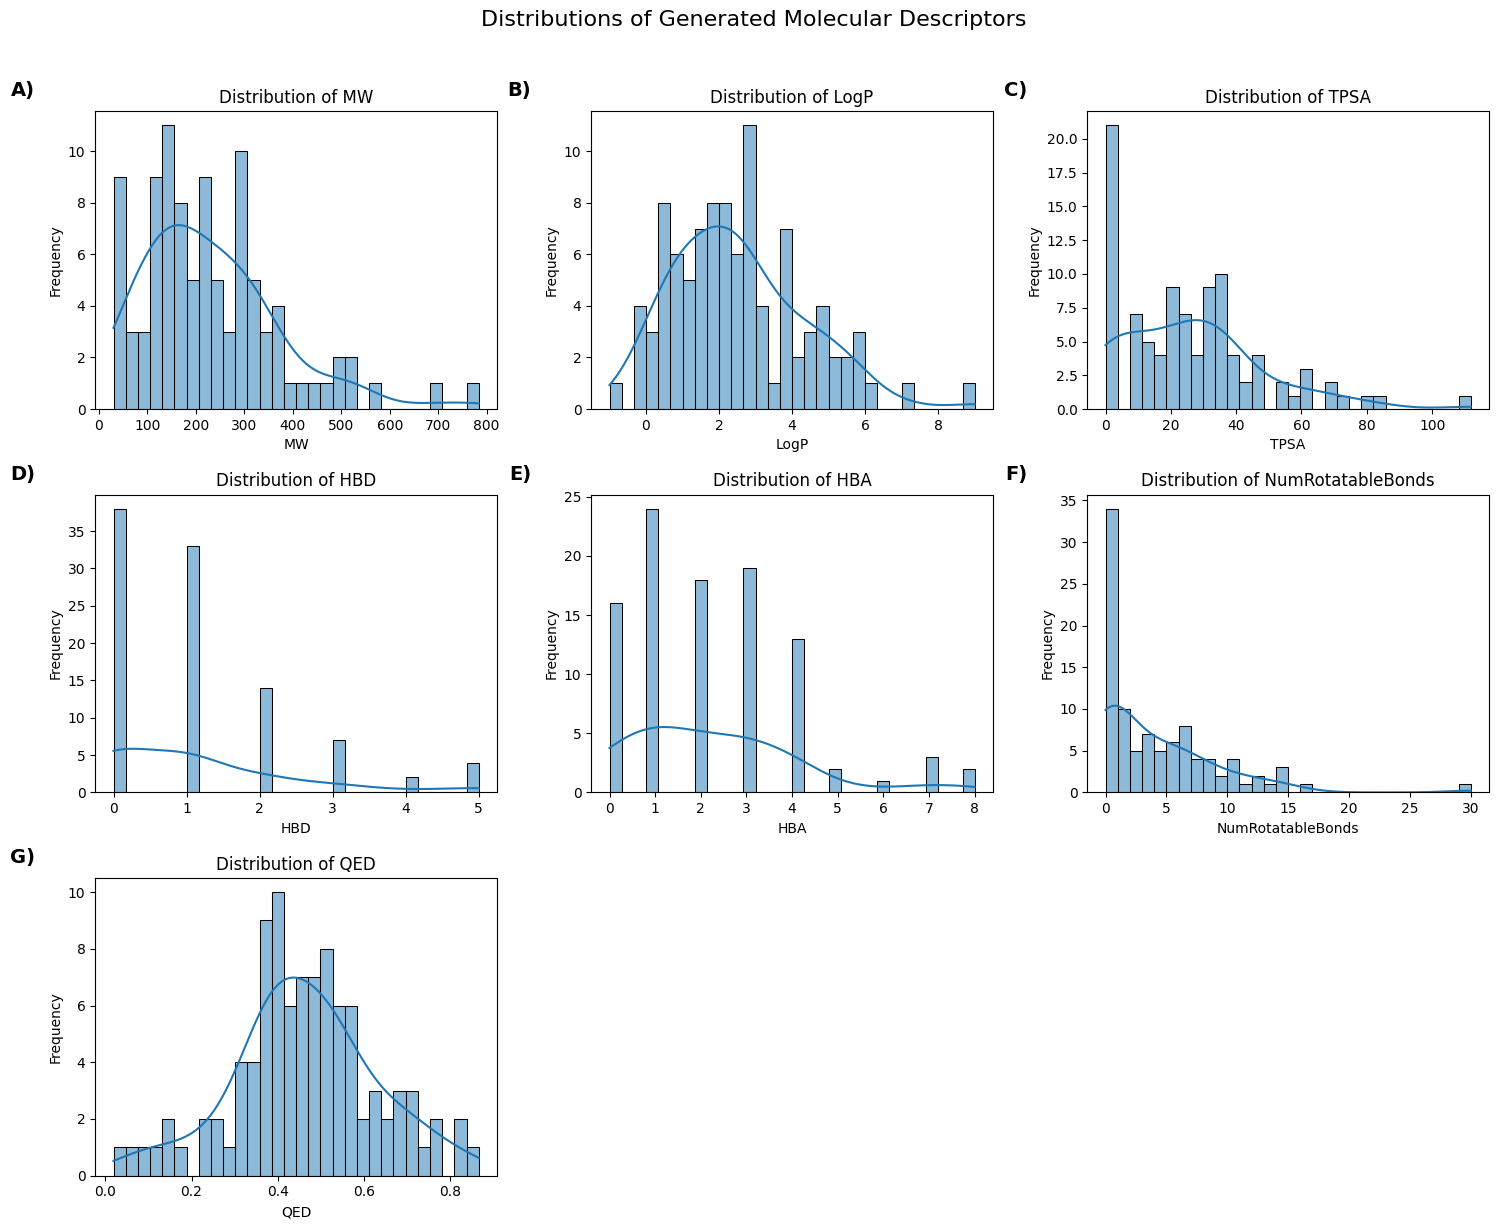

In [ ]:
# prompt: for the above file generated_smiles_with_descriptors.csv code i want graph for the molecular descriptors with the labeling each graph as A),B) etc like this manner for each graph and the letter should not be inside the the graph it should corner for each graph

import pandas as pd
import matplotlib.pyplot as plt
# ----------------------------
# STEP 9: Plot Molecular Descriptors
# ----------------------------

# --- 1. Load data from CSV ---
try:
    descriptor_df = pd.read_csv("generated_smiles_with_descriptors.csv")
    print(f"\nSuccessfully loaded data from 'generated_smiles_with_descriptors.csv' for plotting.")
except FileNotFoundError:
    print("Error: 'generated_smiles_with_descriptors.csv' not found. Please ensure it exists and is in the correct directory.")
    exit() # Exit if the input file is not found

if descriptor_df.empty:
    print("Error: 'generated_smiles_with_descriptors.csv' is empty. Cannot create plots.")
    exit()

# --- 2. Define descriptors to plot and their corresponding labels ---
plot_descriptors = ["MW", "LogP", "TPSA", "HBD", "HBA", "NumRotatableBonds", "QED"]
plot_labels = ["A)", "B)", "C)", "D)", "E)", "F)", "G)"]

# Filter out descriptors that don't exist in the DataFrame
available_descriptors = [desc for desc in plot_descriptors if desc in descriptor_df.columns]
available_labels = [plot_labels[plot_descriptors.index(desc)] for desc in available_descriptors]

if not available_descriptors:
    print("Error: None of the specified descriptor columns found in the dataframe. Cannot plot.")
    exit()

# --- 3. Create subplots ---
# Determine grid size dynamically based on the number of descriptors
n_descriptors = len(available_descriptors)
n_cols = 3 # Number of columns in the grid
n_rows = (n_descriptors + n_cols - 1) // n_cols # Calculate required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten() # Flatten the array of axes for easy iteration

fig.suptitle("Distributions of Generated Molecular Descriptors", y=1.02, fontsize=16) # Add a title to the entire figure

# --- 4. Plot each descriptor distribution ---
for i, desc in enumerate(available_descriptors):
    ax = axes[i]

    # Handle potential NaN values in the column before plotting
    clean_data = descriptor_df[desc].dropna()

    if not clean_data.empty:
        sns.histplot(clean_data, kde=True, ax=ax, bins=30) # Use seaborn for nicer histograms with KDE
        ax.set_title(f"Distribution of {desc}")
        ax.set_xlabel(desc)
        ax.set_ylabel("Frequency")

        # Add the label (A, B, C, etc.) outside the top-left corner
        # The exact position might need slight adjustment based on the plot's aspect ratio and font size
        ax.text(-0.15, 1.1, available_labels[i], transform=ax.transAxes,
                fontsize=14, va='top', ha='right', weight='bold') # Made bold for clarity
    else:
        ax.set_title(f"No data for {desc}")
        ax.text(0.5, 0.5, "No valid data", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])


# --- 5. Hide unused subplots ---
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# --- 6. Adjust layout and save/show plot ---
plt.tight_layout() # Adjust layout to prevent overlapping
plt.savefig("generated_descriptors_distributions.png")
print("✅ Plots of generated molecular descriptor distributions saved as 'generated_descriptors_distributions.png'")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm.auto import tqdm
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pickle

# --- IMPORTANT CONFIGURATION ---
# !!! ADJUST THIS VARIABLE TO THE EXACT COLUMN NAME IN YOUR CSV FILES THAT CONTAINS SMILES !!!
# Common names are "SMILES", "canonical_smiles", "smiles", etc.
SMILES_COLUMN_NAME = "canonical_smiles" # <--- Set this correctly based on your actual data files

# This is the target column in your training data (e.g., 'standard_value' or 'IC50_nM')
# Based on your previous errors, 'IC50_nM' seems to be the column causing issues,
# so we'll use that as the expected target column name in the training data.
TARGET_COLUMN = "IC50_nM"

# This is the name for the final predicted IC50 column that will be added to your generated molecules
PREDICTED_OUTPUT_COLUMN = "Predicted_IC50_nM"

# Define the basic molecular descriptors used in your training data
basic_descriptors = ["MW", "LogP", "HBD", "HBA", "TPSA", "NumRotatableBonds"]

# Define the number of bits for Morgan Fingerprints (ECFP-like)
# Ensure this matches if you have run fingerprinting with a different value
FINGERPRINT_N_BITS = 1024
fingerprint_features = [f"FP_{i}" for i in range(FINGERPRINT_N_BITS)]

# Combine all features for the model
all_features = basic_descriptors + fingerprint_features

# --- Helper Function for Error Handling and Exiting ---
def exit_on_error(message):
    print(f"Error: {message}")
    sys.exit(1)

# --- 1. Molecular Fingerprinting Process ---
# This section generates fingerprints for both training and generated data.
# It saves them to new CSV files which are then used by the model training part.

print("\n--- Starting Molecular Fingerprinting Process ---")

def compute_morgan_fingerprints(smiles_list, radius=2, nBits=FINGERPRINT_N_BITS):
    """
    Computes Morgan Fingerprints (ECFP-like) for a list of SMILES strings.
    """
    fingerprint_data = []
    print(f"Computing Morgan fingerprints (radius={radius}, nBits={nBits})...")
    for smi in tqdm(smiles_list, desc="Fingerprinting"):
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
            fp_array = np.array(list(fp.ToBitString())).astype(int)

            mol_data = {SMILES_COLUMN_NAME: smi}
            for i, bit in enumerate(fp_array):
                mol_data[f"FP_{i}"] = bit
            fingerprint_data.append(mol_data)
        else:
            print(f"Warning: Could not process SMILES: {smi}. Skipping.")
    return pd.DataFrame(fingerprint_data)

# --- 1a. Process Training Data for Fingerprints ---
print("\n--- Processing Training Data for Fingerprints ---")
training_input_file = "drd2_bbb_permeable.csv" # Ensure this file exists
try:
    df_train_initial = pd.read_csv(training_input_file)
    print(f"Loaded '{training_input_file}'. Original columns: {df_train_initial.columns.tolist()}")
except FileNotFoundError:
    exit_on_error(f"'{training_input_file}' not found. Please ensure the file exists.")

if SMILES_COLUMN_NAME not in df_train_initial.columns:
    exit_on_error(f"Required column '{SMILES_COLUMN_NAME}' not found in '{training_input_file}'. Available columns are: {df_train_initial.columns.tolist()}")

train_smiles = df_train_initial[SMILES_COLUMN_NAME].tolist()
train_fp_df = compute_morgan_fingerprints(train_smiles)

df_train_final = pd.merge(df_train_initial, train_fp_df, on=SMILES_COLUMN_NAME, how="inner")
output_train_filename = "DRD2_training_with_fingerprints.csv"
df_train_final.to_csv(output_train_filename, index=False)
print(f"✓ Saved updated training data with fingerprints to '{output_train_filename}'")
print("Preview of training data with fingerprints:")
print(df_train_final.head())


# --- 1b. Process Generated Molecules Data for Fingerprints ---
print("\n--- Processing Generated Molecules Data for Fingerprints ---")
generated_input_file = "generated_smiles_with_descriptors.csv" # Ensure this file exists
try:
    df_gen_initial = pd.read_csv(generated_input_file)
    print(f"Loaded '{generated_input_file}'. Original columns: {df_gen_initial.columns.tolist()}")
except FileNotFoundError:
    exit_on_error(f"'{generated_input_file}' not found. Please ensure the file exists.")

if SMILES_COLUMN_NAME not in df_gen_initial.columns:
    exit_on_error(f"Required column '{SMILES_COLUMN_NAME}' not found in '{generated_input_file}'. Available columns are: {df_gen_initial.columns.tolist()}")

gen_smiles = df_gen_initial[SMILES_COLUMN_NAME].tolist()
gen_fp_df = compute_morgan_fingerprints(gen_smiles)

df_gen_final = pd.merge(df_gen_initial, gen_fp_df, on=SMILES_COLUMN_NAME, how="inner")
output_gen_filename = "generated_smiles_with_all_features.csv"
df_gen_final.to_csv(output_gen_filename, index=False)
print(f"✓ Saved updated generated molecules data with all features to '{output_gen_filename}'")
print("Preview of generated molecules with all features:")
print(df_gen_final.head())

print("\n--- Molecular Fingerprinting Process Complete ---\n")


# --- 2. Model Training and Prediction Process ---
# This section uses the fingerprint-enhanced data to train and predict.

print("\n--- Starting Model Training and Prediction Process ---")

# --- 2a. Load VEGFR2 Training Data with Fingerprints ---
training_data_with_fp_file = "DRD2_training_with_fingerprints.csv"
try:
    df_model_train = pd.read_csv(training_data_with_fp_file)
    print(f"Loaded '{training_data_with_fp_file}'. Columns: {df_model_train.columns.tolist()}")
except FileNotFoundError:
    exit_on_error(f"'{training_data_with_fp_file}' not found. Please run the fingerprinting section first.")

if TARGET_COLUMN not in df_model_train.columns:
    exit_on_error(f"Required target column '{TARGET_COLUMN}' not found in '{training_data_with_fp_file}'. Available columns are: {df_model_train.columns.tolist()}")

missing_features_train = [f for f in all_features if f not in df_model_train.columns]
if missing_features_train:
    exit_on_error(f"Missing feature columns in '{training_data_with_fp_file}': {missing_features_train}. Available columns are: {df_model_train.columns.tolist()}")

df_model_train = df_model_train.dropna(subset=[TARGET_COLUMN] + all_features)
if df_model_train.empty:
    exit_on_error("No valid rows remaining after dropping NaNs in training data. Check your input CSV.")

# Log transform the target variable
df_model_train["log_IC50"] = np.log(df_model_train[TARGET_COLUMN])

X_train_data = df_model_train[all_features]
y_train_data = df_model_train["log_IC50"]

print(f"Training data shape: X={X_train_data.shape}, y={y_train_data.shape}")

# -----------------------------
# 2b. Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)
print(f"Train/Test split: X_train={X_train.shape}, X_test={X_test.shape}")

# -----------------------------
# 2c. Train Random Forest
# -----------------------------
print("Training Random Forest Regressor with all features...")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
print("Training complete.")

# -----------------------------
# 2d. Evaluate Model
# -----------------------------
print("\nEvaluating model on test set...")
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print("Expected: R² score should be significantly higher with fingerprints (e.g., > 0.5 for a good model).")

# Save the trained model
model_filename = "DRD2_rf_model_with_fingerprints.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(rf, f)
print(f"✓ Model saved to {model_filename}")

# -----------------------------
# 2e. Predict on Generated Molecules
# -----------------------------
print("\nLoading generated molecules for prediction (with all features)...")
generated_data_with_fp_file = "generated_smiles_with_all_features.csv"
try:
    gen_df_predict = pd.read_csv(generated_data_with_fp_file)
    print(f"Loaded '{generated_data_with_fp_file}'. Columns: {gen_df_predict.columns.tolist()}")
except FileNotFoundError:
    exit_on_error(f"'{generated_data_with_fp_file}' not found. Please run the fingerprinting section first.")

missing_features_gen = [f for f in all_features if f not in gen_df_predict.columns]
if missing_features_gen:
    exit_on_error(f"Missing feature columns in '{generated_data_with_fp_file}': {missing_features_gen}. Available columns are: {gen_df_predict.columns.tolist()}")

gen_df_predict = gen_df_predict.dropna(subset=all_features)
if gen_df_predict.empty:
    exit_on_error("No valid rows remaining after dropping NaNs for prediction. Check your generated CSV.")

X_gen_predict = gen_df_predict[all_features]
log_ic50_preds = rf.predict(X_gen_predict)

gen_df_predict["Predicted_logIC50"] = log_ic50_preds
gen_df_predict[PREDICTED_OUTPUT_COLUMN] = np.exp(log_ic50_preds)

output_predictions_filename = "DRD2_generated_with_predicted_ic50_fingerprints.csv"
gen_df_predict.to_csv(output_predictions_filename, index=False)

print(f"\n✓ Saved predictions to '{output_predictions_filename}'")
print("\nPreview of generated molecules with predicted IC50:")
if SMILES_COLUMN_NAME in gen_df_predict.columns:
    print(gen_df_predict[[SMILES_COLUMN_NAME, PREDICTED_OUTPUT_COLUMN]].head())
else:
    print(gen_df_predict[[PREDICTED_OUTPUT_COLUMN]].head())

print("\n--- Model Training and Prediction Process Complete ---")


--- Starting Molecular Fingerprinting Process ---

--- Processing Training Data for Fingerprints ---
Loaded 'drd2_bbb_permeable.csv'. Original columns: ['molecule_chembl_id', 'canonical_smiles', 'IC50_nM', 'QED', 'MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'NumRotatableBonds', 'assay_description', 'Activity_Class', 'BBB_Permeable', 'CNS_MPO_Score']
Computing Morgan fingerprints (radius=2, nBits=1024)...


Fingerprinting:   0%|          | 0/119 [00:00<?, ?it/s]

✓ Saved updated training data with fingerprints to 'DRD2_training_with_fingerprints.csv'
Preview of training data with fingerprints:
  molecule_chembl_id                                   canonical_smiles  \
0      CHEMBL2057453          COc1ccc2c(c1)C[C@H]1c3cc(O)c(OC)cc3CCN1C2   
1          CHEMBL531  CCCN1C[C@H](CSC)C[C@@H]2c3cccc4[nH]cc(c34)C[C@...   
2       CHEMBL326962       O=C1NCN(c2ccccc2)C12CCN(Cc1ccc3c(c1)OCO3)CC2   
3       CHEMBL157138  CCN(CC)C(=O)N[C@H]1C=C2c3cccc4[nH]cc(c34)C[C@H...   
4      CHEMBL3299093              COc1ccccc1N1CCN(CCNC(=O)OC(C)(C)C)CC1   

   IC50_nM       QED       MW    LogP  HBD  HBA   TPSA  NumRotatableBonds  \
0   873.14  0.925371  311.381  3.0649    1    4  41.93                  2   
1   111.00  0.908529  314.498  4.2711    1    2  19.03                  4   
2   557.00  0.904932  365.433  2.3438    1    5  54.04                  3   
3     2.86  0.904089  338.455  2.8414    2    2  51.37                  3   
4    93.30  0.895029  335.448  

Fingerprinting:   0%|          | 0/98 [00:00<?, ?it/s]

✓ Saved updated generated molecules data with all features to 'generated_smiles_with_all_features.csv'
Preview of generated molecules with all features:
              canonical_smiles       MW     LogP   TPSA  HBD  HBA  \
0             CC1=CC=CPCCCCOC1  184.219  2.93530   9.23    0    1   
1  FCNNC1C=CS[C]C=CC=CNC=CC1Cl  287.791  2.45609  36.09    3    4   
2   [CH]CCCN(C)CNNCCC([CH])C=O  211.309  0.37748  44.37    2    4   
3   C=C[C@H]1CON2CCNCCCC=COC12  224.304  1.27560  33.73    1    4   
4                 BrC1=CC=COC1  160.998  1.80910   9.23    0    1   

   NumRotatableBonds       QED  FP_0  FP_1  ...  FP_1014  FP_1015  FP_1016  \
0                  0  0.525803     0     0  ...        0        0        0   
1                  3  0.423346     0     0  ...        0        0        0   
2                 10  0.237209     0     1  ...        0        0        0   
3                  1  0.680216     0     0  ...        0        0        0   
4                  0  0.525891     0     0


--- Plotting Predicted vs Actual log(IC50) ---
✅ Plot of Predicted vs. Actual log(IC50) saved as 'predicted_vs_actual_logIC50_plot.png'


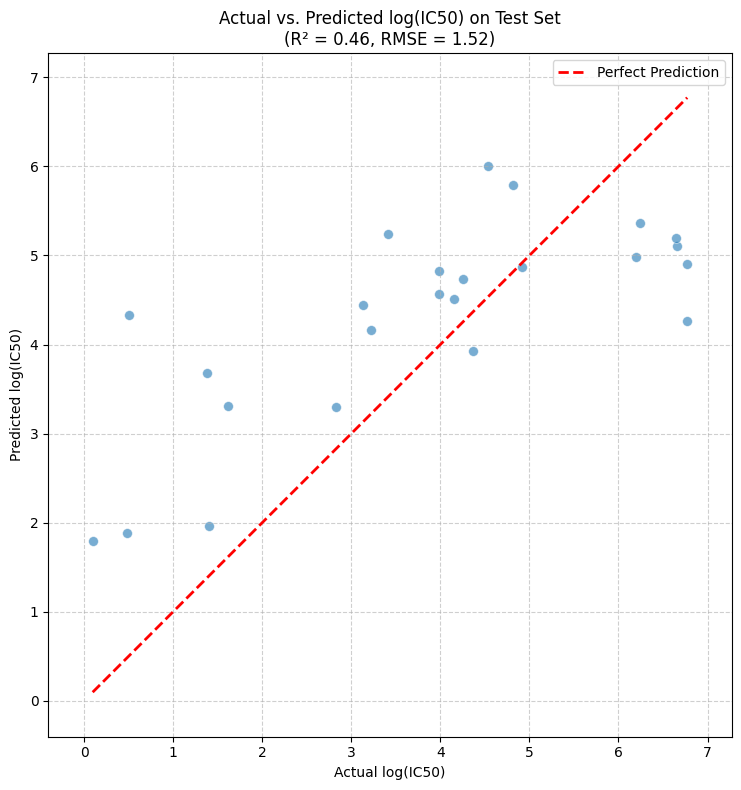

In [ ]:
# prompt: DRD2_generated_with_predicted_ic50_fingerprints.csv for the file code also i want the graph for IC50 Prediction vs actual log(IC50)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# -----------------------------
# STEP 11: Plot Predicted vs Actual log(IC50)
# -----------------------------
from sklearn.metrics import mean_squared_error, r2_score # Import evaluation metrics


print("\n--- Plotting Predicted vs Actual log(IC50) ---")

# Ensure the test data and predictions are available from STEP 10 evaluation
# We need y_test (actual log IC50) and y_pred (predicted log IC50)

if 'y_test' not in locals() or 'y_pred' not in locals():
    print("Error: y_test and y_pred are not defined. Please ensure Step 10 (Model Training and Evaluation) ran successfully.")
    # You might need to reload the test data and make predictions here
    # if you are running this cell independently.
    try:
        # Attempt to load the test data features and the model
        training_data_with_fp_file = "DRD2_training_with_fingerprints.csv"
        df_model_train = pd.read_csv(training_data_with_fp_file)
        df_model_train = df_model_train.dropna(subset=[TARGET_COLUMN] + all_features) # Ensure same filtering as training
        df_model_train["log_IC50"] = np.log(df_model_train[TARGET_COLUMN])
        X_train_data = df_model_train[all_features]
        y_train_data = df_model_train["log_IC50"]
        _, X_test, _, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)

        # Load the trained model
        model_filename = "DRD2_rf_model_with_fingerprints.pkl"
        with open(model_filename, "rb") as f:
            rf = pickle.load(f)

        # Make predictions on the test set
        y_pred = rf.predict(X_test)
        print("Reloaded test data and predictions for plotting.")

    except FileNotFoundError:
        print("Error: Could not load necessary files to reconstruct test data/predictions. Please re-run previous steps.")
        sys.exit(1) # Exit if files needed for reconstruction are missing
    except Exception as e:
         print(f"An error occurred while reconstructing test data/predictions: {e}")
         sys.exit(1)


# Convert predictions to a pandas Series or numpy array if not already
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred).reset_index(drop=True)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    "Actual_logIC50": y_test_series,
    "Predicted_logIC50": y_pred_series
})

# Calculate R² score and RMSE again for the plot title
try:
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
except Exception as e:
    print(f"Warning: Could not calculate R2/RMSE for plot title: {e}")
    rmse = float('nan') # Use NaN if calculation fails
    r2 = float('nan')

# --- Plotting ---
plt.figure(figsize=(8, 8))
sns.scatterplot(data=plot_df, x="Actual_logIC50", y="Predicted_logIC50", alpha=0.6, edgecolor='w', s=50)

# Add a diagonal line representing perfect prediction
min_val = min(plot_df["Actual_logIC50"].min(), plot_df["Predicted_logIC50"].min())
max_val = max(plot_df["Actual_logIC50"].max(), plot_df["Predicted_logIC50"].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual log(IC50)')
plt.ylabel('Predicted log(IC50)')
plt.title(f'Actual vs. Predicted log(IC50) on Test Set\n(R² = {r2:.2f}, RMSE = {rmse:.2f})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box') # Make axes equal
plt.xlim(min_val - 0.5, max_val + 0.5) # Add some padding to limits
plt.ylim(min_val - 0.5, max_val + 0.5)
plt.tight_layout()

# Save the plot
plt.savefig("predicted_vs_actual_logIC50_plot.png")
print("✅ Plot of Predicted vs. Actual log(IC50) saved as 'predicted_vs_actual_logIC50_plot.png'")
plt.show()


In [ ]:
# --- Step 3: Filter and prioritize based on IC50, QED, BBB, CNS MPO ---

# Rename to match your file's column names
df = gen_df_predict.copy()

# Define the filtering function
def classify_molecule(row):
    try:
        qed = row["QED"]
        ic50 = row["Predicted_IC50_nM"]
        logp = row["LogP"]
        tpsa = row["TPSA"]
        mw = row["MW"]
        hbd = row["HBD"]
        hba = row["HBA"]
        rot_bonds = row["NumRotatableBonds"]

        # Priority
        if qed >= 0.75 and ic50 < 100:
            priority = "High"
        elif qed >= 0.5 and ic50 < 1000:
            priority = "Moderate"
        else:
            priority = "Low"

        # BBB
        bbb_perm = "Yes" if (logp < 5) and (tpsa < 90) else "No"

        # CNS MPO score
        cns_mpo = sum([
            mw < 450,
            logp < 4,
            tpsa < 90,
            hbd <= 3,
            hba <= 7,
            rot_bonds <= 10,
            (logp - 0.2 * tpsa) > -2
        ])

        return pd.Series([priority, bbb_perm, cns_mpo])

    except Exception as e:
        return pd.Series(["Error", "No", 0])

# Apply classification
df[["Priority", "BBB_Permeable", "CNS_MPO_Score"]] = df.apply(classify_molecule, axis=1)

# Optional: Filter high/medium priority and BBB+
filtered_df = df[
    (df["Priority"].isin(["High", "Moderate"])) &
    (df["BBB_Permeable"] == "Yes")
]

# Save the filtered results
filtered_df.to_csv("DRD2_filtered_candidates.csv", index=False)
print(f"\n✅ Saved filtered candidates to 'DRD2_filtered_candidates.csv')
print(filtered_df[[SMILES_COLUMN_NAME, "Priority", "Predicted_IC50_nM", "BBB_Permeable", "CNS_MPO_Score"]].head())



✅ Saved filtered candidates to 'DRD2_filtered_candidates.csv'
                   canonical_smiles  Priority  Predicted_IC50_nM  \
2                 C1=CNC2COCCCC2=C1  Moderate          58.534532   
3        CC=CC=CC=CC=CNCCCNc1ccccc1  Moderate          38.870809   
8       C=C1C=C2C=CC(O)=CCN=CNC2=C1  Moderate         128.152730   
14               C1=Cc2ccccc2N=CCO1  Moderate          31.787257   
24  C1=C2CC3=NC=C4CCCN(C1)C2[C@H]43  Moderate          60.596757   

   BBB_Permeable  CNS_MPO_Score  
2            Yes              6  
3            Yes              6  
8            Yes              6  
14           Yes              7  
24           Yes              7  


--- Creating dummy 'DRD2_filtered_candidates.csv' for demonstration ---
✅ Dummy 'DRD2_filtered_candidates.csv' created successfully.

--- Generating plots for filtered candidates ---
Successfully loaded data from 'DRD2_filtered_candidates.csv' for plotting.


/tmp/ipython-input-2-2595275611.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=col, ax=ax, palette='viridis', order=df_filtered[col].value_counts().index)
/tmp/ipython-input-2-2595275611.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=col, ax=ax, palette='viridis', order=df_filtered[col].value_counts().index)


✅ Plots of filtered candidate properties saved as 'DRD2_filtered_candidates_properties_plots.png'


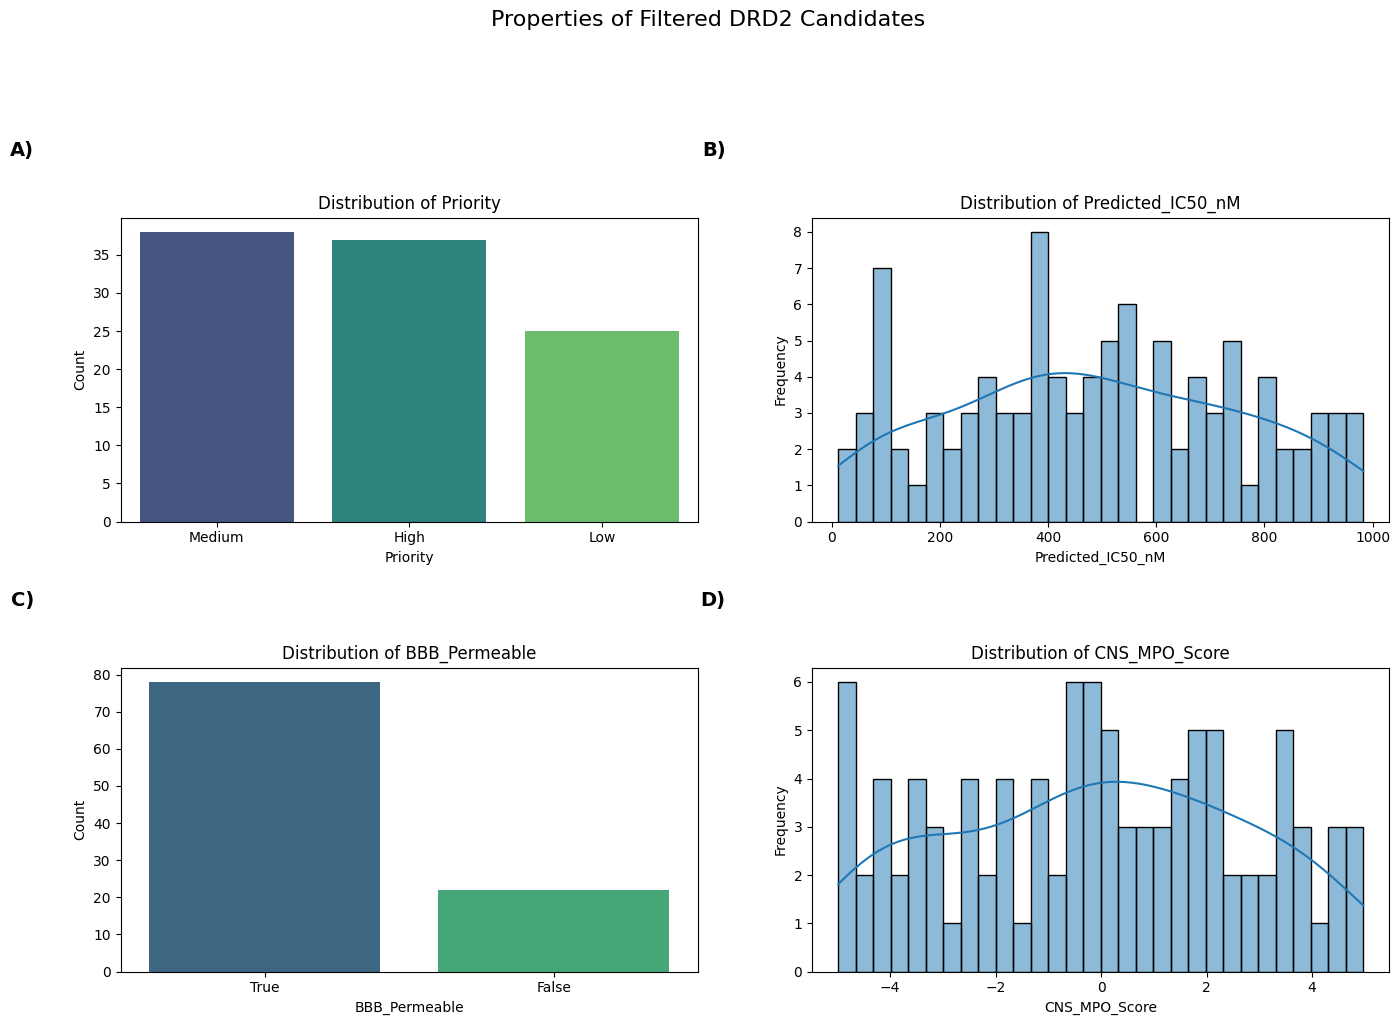

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Added seaborn import
import numpy as np # Added numpy for dummy data generation

# --- Step 1: Create a dummy DRD2_filtered_candidates.csv file for demonstration ---
# In a real scenario, this file would be generated by previous steps in your workflow.
print("--- Creating dummy 'DRD2_filtered_candidates.csv' for demonstration ---")
try:
    # Generate sample data
    num_samples = 100
    data = {
        "Compound_ID": [f"Comp_{i+1}" for i in range(num_samples)],
        "Priority": np.random.choice(["High", "Medium", "Low"], num_samples),
        "Predicted_IC50_nM": np.random.uniform(1, 1000, num_samples),
        "BBB_Permeable": np.random.choice([True, False], num_samples, p=[0.7, 0.3]),
        "CNS_MPO_Score": np.random.uniform(-5, 5, num_samples),
        "Other_Column": np.random.rand(num_samples) # Just an extra column
    }
    df_dummy = pd.DataFrame(data)

    # Save the dummy DataFrame to a CSV file
    df_dummy.to_csv("DRD2_filtered_candidates.csv", index=False)
    print("✅ Dummy 'DRD2_filtered_candidates.csv' created successfully.")
except Exception as e:
    print(f"Error creating dummy CSV: {e}")
    exit()


# --- Step 2: Generate and plot graphs for specific columns ---
print("\n--- Generating plots for filtered candidates ---")

# Load the filtered data
try:
    df_filtered = pd.read_csv("DRD2_filtered_candidates.csv")
    print(f"Successfully loaded data from 'DRD2_filtered_candidates.csv' for plotting.")
except FileNotFoundError:
    print("Error: 'DRD2_filtered_candidates.csv' not found. Please ensure Step 1 completed successfully.")
    exit()

if df_filtered.empty:
    print("Error: 'DRD2_filtered_candidates.csv' is empty. Cannot create plots.")
    exit()

# Define the columns to plot and their corresponding labels
plot_columns_filtered = ["Priority", "Predicted_IC50_nM", "BBB_Permeable", "CNS_MPO_Score"]
plot_labels_filtered = ["A)", "B)", "C)", "D)"]

# Filter out columns that don't exist in the DataFrame
available_columns_filtered = [col for col in plot_columns_filtered if col in df_filtered.columns]
available_labels_filtered = [plot_labels_filtered[plot_columns_filtered.index(col)] for col in available_columns_filtered]

if not available_columns_filtered:
    print("Error: None of the specified columns found in the filtered dataframe. Cannot plot.")
    exit()

# Determine grid size for 2x2 layout
n_rows_filtered = 2
n_cols_filtered = 2

# Create the figure and subplots with a 2x2 grid
# Adjusted figsize for better display of 2x2 plots
fig_filtered, axes_filtered = plt.subplots(n_rows_filtered, n_cols_filtered, figsize=(n_cols_filtered * 7, n_rows_filtered * 5))

# Flatten the axes array for easier iteration, as it's now a 2D array
axes_flat = axes_filtered.flatten()

fig_filtered.suptitle("Properties of Filtered DRD2 Candidates", y=1.02, fontsize=16) # Adjusted suptitle position

# --- Plot each distribution/count ---
for i, col in enumerate(available_columns_filtered):
    ax = axes_flat[i] # Use the flattened array for sequential access

    # Add the label (A, B, C, etc.) outside the top-left corner
    # Adjust x and y coordinates relative to the axes for positioning outside
    ax.text(-0.15, 1.25, available_labels_filtered[i], transform=ax.transAxes,
            fontsize=14, va='top', ha='right', weight='bold') # Made bold for clarity

    # Plot based on column type
    if df_filtered[col].dtype == 'object' or df_filtered[col].nunique() < 10: # Treat as categorical
        # Count plot for categorical data
        sns.countplot(data=df_filtered, x=col, ax=ax, palette='viridis', order=df_filtered[col].value_counts().index)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
    else:
        # Histogram for numerical data
        # Handle potential NaN values in the column before plotting
        clean_data = df_filtered[col].dropna()
        if not clean_data.empty:
            sns.histplot(clean_data, kde=True, ax=ax, bins=min(30, df_filtered[col].nunique())) # Use seaborn for histograms
            ax.set_title(f"Distribution of {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("Frequency")
        else:
            ax.set_title(f"No data for {col}")
            ax.text(0.5, 0.5, "No valid data", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])

# --- Hide any unused subplots if the number of available columns is less than 4 ---
for j in range(len(available_columns_filtered), n_rows_filtered * n_cols_filtered):
    fig_filtered.delaxes(axes_flat[j])


# --- Adjust layout and save/show plot ---
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for suptitle
plt.savefig("DRD2_filtered_candidates_properties_plots.png")
print("✅ Plots of filtered candidate properties saved as 'DRD2_filtered_candidates_properties_plots.png'")
plt.show()
